

**1.** create a CNN Model and Train it.

**2.** evaluate the model on test set using different classification metrics.

**3.** visualize the images present in the training and test set.




### **1. Import the Required Libraries**

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import cv2
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
import warnings
warnings.filterwarnings('ignore')

from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, BatchNormalization, Conv2D, Dense, Dropout, Flatten, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

### **2. Load the Image Training and Validation Datasets**

#### **i. Get the Image Dataset Paths**

In [2]:
train_dataset_path = './data'
validation_dataset_path = './data'

#### **ii. Load Image Datasets and Apply Augmentations**

Since the images present in the datasets are 150x150px in size, the image height and width are taken as 150, 150 respectively. The batch size value can be changed if required.

In [3]:
IMG_WIDTH = 150
IMG_HEIGHT = 150
BATCH_SIZE = 32

Loading the training dataset and applying augmentations on it.

In [4]:
train_datagen = ImageDataGenerator(rescale=1.0/255,
                                  zoom_range=0.2,
                                  width_shift_range=0.2,
                                  height_shift_range=0.2,
                                  fill_mode='nearest')
train_generator = train_datagen.flow_from_directory(train_dataset_path,
                                                   target_size=(IMG_WIDTH, IMG_HEIGHT),
                                                   batch_size=BATCH_SIZE,
                                                   class_mode='categorical',
                                                   shuffle=True)

Found 8993 images belonging to 5 classes.


Loading the validation dataset.

In [5]:
validation_datagen = ImageDataGenerator(rescale=1.0/255)
validation_generator = validation_datagen.flow_from_directory(validation_dataset_path,
                                                             target_size=(IMG_WIDTH, IMG_HEIGHT),
                                                             batch_size=BATCH_SIZE,
                                                             class_mode='categorical',
                                                             shuffle=True)

Found 8993 images belonging to 5 classes.


#### **iii. Get the Label Mappings**

The labels dictionary is made in order to retrive the class names against the label indices used for training the model

In [6]:
labels = {value: key for key, value in train_generator.class_indices.items()}

print("Label Mappings for classes present in the training and validation datasets\n")
for key, value in labels.items():
    print(f"{key} : {value}")

Label Mappings for classes present in the training and validation datasets

0 : Cat
1 : Cow
2 : Dog
3 : Donkey
4 : Goat


### **3. Plotting Sample Training Images**

In [7]:
len(labels)

5

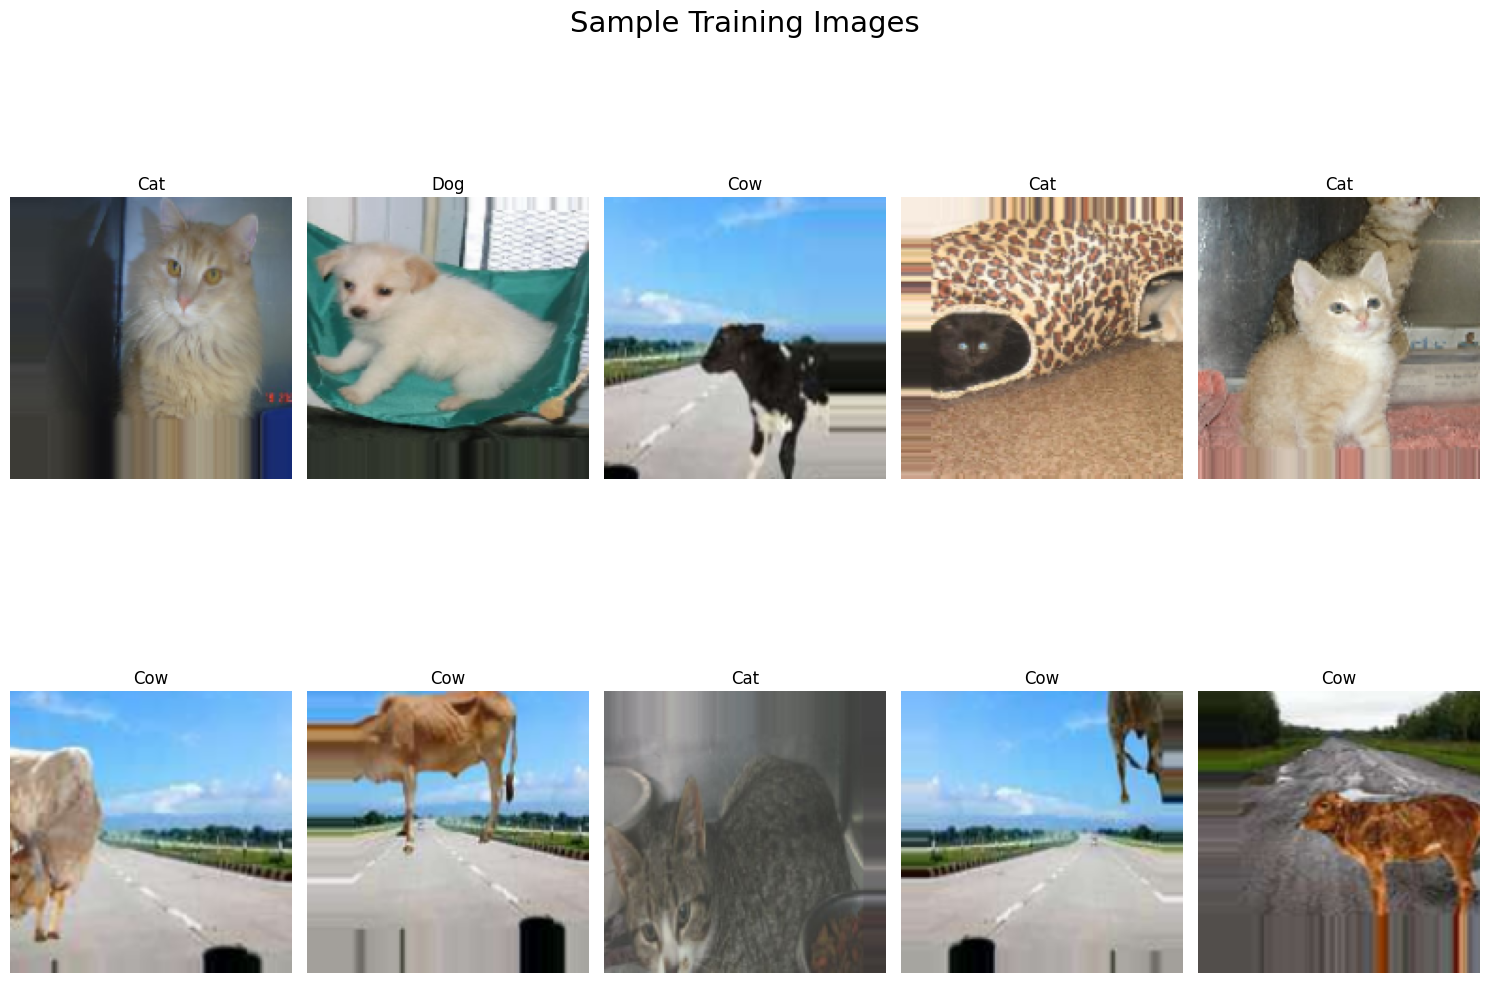

In [8]:
fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(15, 12))
idx = 0

for i in range(2):
    for j in range(5):
        label = labels[np.argmax(train_generator[0][1][idx])]
        ax[i, j].set_title(f"{label}")
        ax[i, j].imshow(train_generator[0][0][idx][:, :, :])
        ax[i, j].axis("off")
        idx += 1

plt.tight_layout()
plt.suptitle("Sample Training Images", fontsize=21)
plt.show()

### **4. Training a CNN Model**

Since the training dataset is ready let's create a simple CNN Model to train on the image datasets

#### **i. Create a CNN Model**

In [9]:
def create_model():
    model = Sequential([
        Conv2D(filters=128, kernel_size=(5, 5), padding='valid', input_shape=(IMG_WIDTH, IMG_HEIGHT, 3)),
        Activation('relu'),
        MaxPooling2D(pool_size=(2, 2)),
        BatchNormalization(),
        
        Conv2D(filters=64, kernel_size=(3, 3), padding='valid', kernel_regularizer=l2(0.00005)),
        Activation('relu'),
        MaxPooling2D(pool_size=(2, 2)),
        BatchNormalization(),
        
        Conv2D(filters=32, kernel_size=(3, 3), padding='valid', kernel_regularizer=l2(0.00005)),
        Activation('relu'),
        MaxPooling2D(pool_size=(2, 2)),
        BatchNormalization(),
        
        Flatten(),
        
        Dense(units=256, activation='relu'),
        Dropout(0.5),
        Dense(units=len(labels), activation='softmax')
    ])
    
    return model

In [10]:
cnn_model = create_model()

In [11]:
print(cnn_model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 146, 146, 128)     9728      
                                                                 
 activation (Activation)     (None, 146, 146, 128)     0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 73, 73, 128)       0         
 D)                                                              
                                                                 
 batch_normalization (Batch  (None, 73, 73, 128)       512       
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 71, 71, 64)        73792     
                                                                 
 activation_1 (Activation)   (None, 71, 71, 64)        0

#### **ii. Defining Callbacks**

A callback is an object that can perform actions at various stages of training (e.g. at the start or end of an epoch, before or after a single batch, etc)

#### **a. Reduce Learning Rate on Plateau**

Is used to reduce the learning rate when a metric has stopped improving.

In [12]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=np.sqrt(0.1), patience=5)

#### **iii. Defining the Optimizer**

In [13]:
optimizer = Adam(learning_rate=0.001)

#### **iv. Compile the Model**

In [14]:
cnn_model.compile(optimizer=optimizer, loss=CategoricalCrossentropy(), metrics=['accuracy'])

#### **v. Training the Model**

In [15]:
history = cnn_model.fit(train_generator, epochs=10, validation_data=validation_generator,
                       verbose=2,

                        callbacks=[reduce_lr])

Epoch 1/10


282/282 - 538s - loss: 1.1755 - accuracy: 0.6418 - val_loss: 0.8560 - val_accuracy: 0.6563 - lr: 0.0010 - 538s/epoch - 2s/step
Epoch 2/10
282/282 - 533s - loss: 0.8326 - accuracy: 0.6680 - val_loss: 0.6791 - val_accuracy: 0.6903 - lr: 0.0010 - 533s/epoch - 2s/step
Epoch 3/10
282/282 - 575s - loss: 0.7301 - accuracy: 0.6902 - val_loss: 4.3133 - val_accuracy: 0.1411 - lr: 0.0010 - 575s/epoch - 2s/step
Epoch 4/10
282/282 - 560s - loss: 0.6889 - accuracy: 0.6932 - val_loss: 0.6382 - val_accuracy: 0.7071 - lr: 0.0010 - 560s/epoch - 2s/step
Epoch 5/10
282/282 - 3221s - loss: 0.6782 - accuracy: 0.7020 - val_loss: 1.0635 - val_accuracy: 0.6704 - lr: 0.0010 - 3221s/epoch - 11s/step
Epoch 6/10
282/282 - 749s - loss: 0.6315 - accuracy: 0.7118 - val_loss: 0.5645 - val_accuracy: 0.7495 - lr: 0.0010 - 749s/epoch - 3s/step
Epoch 7/10
282/282 - 662s - loss: 0.6191 - accuracy: 0.7174 - val_loss: 2.2718 - val_accuracy: 0.3503 - lr: 0.0010 - 662s/epoch - 2s/step
Epoch 8/10
282/282 - 630s - l

In [16]:
import pickle
with open('path_to_save_history.pkl', 'wb') as f:
    pickle.dump(history.history, f)


In [18]:
from keras.preprocessing import image
import numpy as np

# Load the image from the directory
img_path = './data/Cow/fgbg002296.jpg'
img = image.load_img(img_path, target_size=(IMG_WIDTH, IMG_HEIGHT))

# Convert the image to a numpy array
img_array = image.img_to_array(img)

# Expand the dimensions of the image to match the input shape of the model
img_array = np.expand_dims(img_array, axis=0)

# Preprocess the image using the same preprocessing steps as the training data
img_array = img_array / 255.0

# Predict the output of the image
prediction = cnn_model.predict(img_array)

# Get the class label with the highest probability
class_label = np.argmax(prediction)

# Map the class label to the actual class name using the label mappings
class_name = labels[class_label]

# Print the predicted class name
print("Predicted class name:", class_name)


1/1 [==============================] - 0s 390ms/step
Predicted class name: Cow


In [ ]:
### **5. Plotting the Model Metrics**

In [ ]:
#### **i. Plotting training and validation accuracy, loss and learning rate**

In [19]:
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

train_loss = history.history['loss']
val_loss = history.history['val_loss']

learning_rate = history.history['lr']

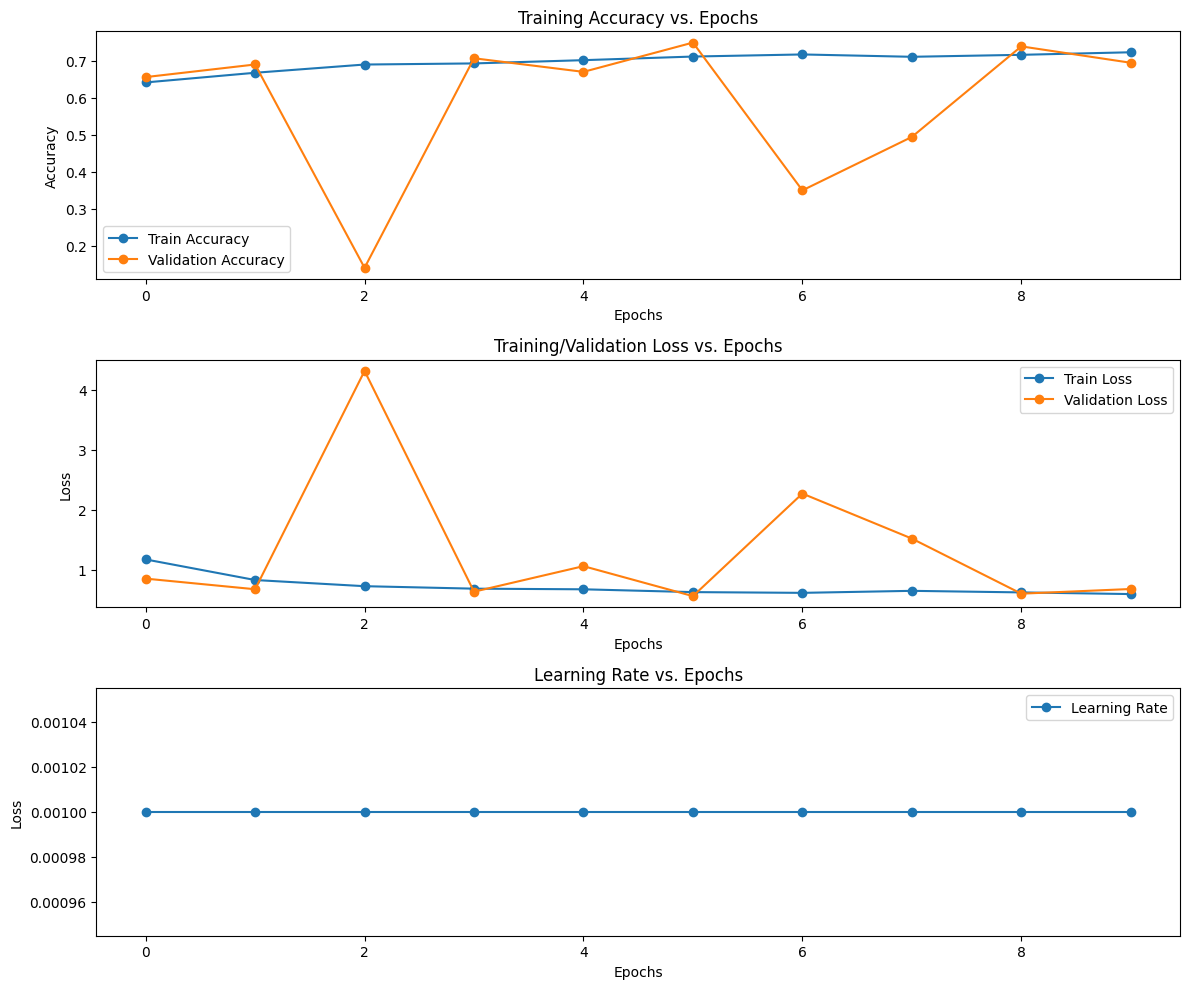

In [20]:
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(12, 10))

ax[0].set_title('Training Accuracy vs. Epochs')
ax[0].plot(train_accuracy, 'o-', label='Train Accuracy')
ax[0].plot(val_accuracy, 'o-', label='Validation Accuracy')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
ax[0].legend(loc='best')

ax[1].set_title('Training/Validation Loss vs. Epochs')
ax[1].plot(train_loss, 'o-', label='Train Loss')
ax[1].plot(val_loss, 'o-', label='Validation Loss')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')
ax[1].legend(loc='best')

ax[2].set_title('Learning Rate vs. Epochs')
ax[2].plot(learning_rate, 'o-', label='Learning Rate')
ax[2].set_xlabel('Epochs')
ax[2].set_ylabel('Loss')
ax[2].legend(loc='best')

plt.tight_layout()
plt.show()

In [21]:
#Testing the model on the validation dataset because a seperate dataset for testing is not available.

In [22]:
### **6. Testing the Model on Test Set**

In [23]:
test_dataset = './data'

In [24]:
test_datagen = ImageDataGenerator(rescale=1.0/255)

test_generator = test_datagen.flow_from_directory(test_dataset,
                                                 shuffle=False,
                                                 batch_size=BATCH_SIZE,
                                                 target_size = (IMG_WIDTH, IMG_HEIGHT),
                                                 class_mode='categorical')

Found 8993 images belonging to 5 classes.


In [25]:
### **7. Model Prediction on the Test Dataset**

In [26]:
predictions = cnn_model.predict(test_generator)

282/282 [==============================] - 82s 288ms/step


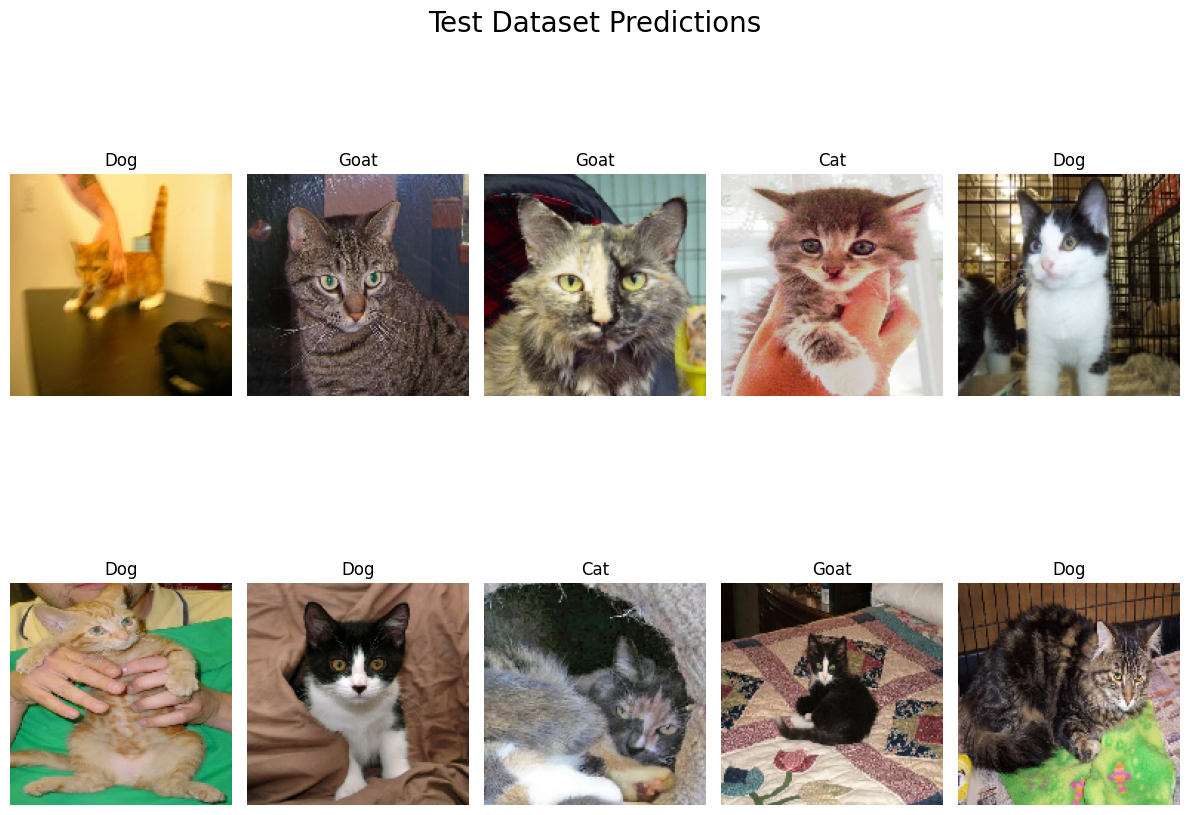

In [27]:
fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(12, 10))
idx = 0

for i in range(2):
    for j in range(5):
        predicted_label = labels[np.argmax(predictions[idx])]
        ax[i, j].set_title(f"{predicted_label}")
        ax[i, j].imshow(test_generator[0][0][idx])
        ax[i, j].axis("off")
        idx += 1

plt.tight_layout()
plt.suptitle("Test Dataset Predictions", fontsize=20)
plt.show()

In [28]:
test_loss, test_accuracy = cnn_model.evaluate(test_generator, batch_size=BATCH_SIZE)

282/282 [==============================] - 85s 302ms/step - loss: 0.6831 - accuracy: 0.6950


In [29]:
print(f"Test Loss:     {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

Test Loss:     0.6831304430961609
Test Accuracy: 0.6949849724769592


In [ ]:
# The test loss and test accuracy is the same as validation loss and validation accuracy at the last step since the testing and validation datasets are same.

In [ ]:
### **8. Plotting the Classification Metrics**

In [ ]:
### **i. Confusion Matrix**

In [30]:
y_pred = np.argmax(predictions, axis=1)
y_true = test_generator.classes

Shape of confusion matrix: (5, 5)
Length of box_labels: 25


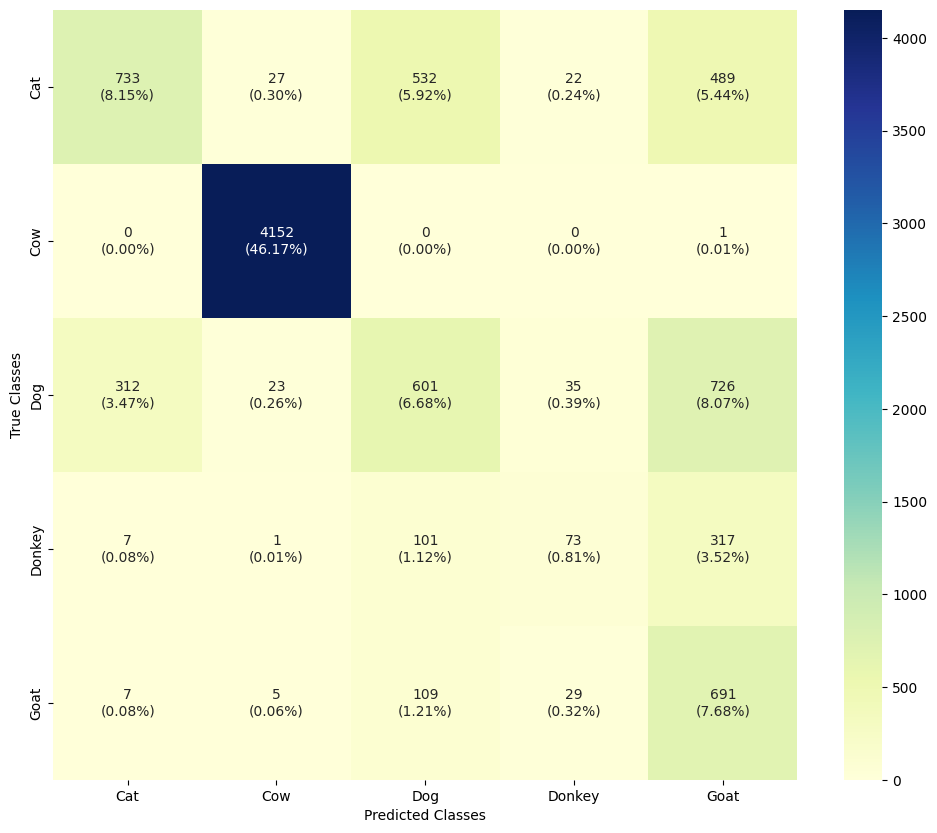

In [31]:
cf_mtx = confusion_matrix(y_true, y_pred)

group_counts = ["{0:0.0f}".format(value) for value in cf_mtx.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cf_mtx.flatten()/np.sum(cf_mtx)]
box_labels = [f"{v1}\n({v2})" for v1, v2 in zip(group_counts, group_percentages)]

# Debug information
print("Shape of confusion matrix:", cf_mtx.shape)
print("Length of box_labels:", len(box_labels))

box_labels = np.asarray(box_labels).reshape(cf_mtx.shape[0], cf_mtx.shape[1])  # Dynamically reshape based on cf_mtx shape

plt.figure(figsize=(12, 10))
sns.heatmap(cf_mtx, xticklabels=labels.values(), yticklabels=labels.values(),
            cmap="YlGnBu", fmt="", annot=box_labels)
plt.xlabel('Predicted Classes')
plt.ylabel('True Classes')
plt.show()


In [ ]:
### **9. Wrong Predictions**

# Let's see where the model has given wrong predictions and what were the actual predictions on those images.

In [32]:
print(classification_report(y_true, y_pred, target_names=labels.values()))


              precision    recall  f1-score   support

         Cat       0.69      0.41      0.51      1803
         Cow       0.99      1.00      0.99      4153
         Dog       0.45      0.35      0.40      1697
      Donkey       0.46      0.15      0.22       499
        Goat       0.31      0.82      0.45       841

    accuracy                           0.69      8993
   macro avg       0.58      0.55      0.51      8993
weighted avg       0.73      0.69      0.69      8993



In [36]:
errors = (y_true - y_pred != 0)
y_true_errors = y_true[errors]
y_pred_errors = y_pred[errors]
print(errors,y_true_errors,y_pred_errors)

[ True  True  True ... False False False] [0 0 0 ... 4 4 4] [2 4 4 ... 2 2 2]


In [37]:
test_images = test_generator.filenames
test_img = np.asarray(test_images)[errors]

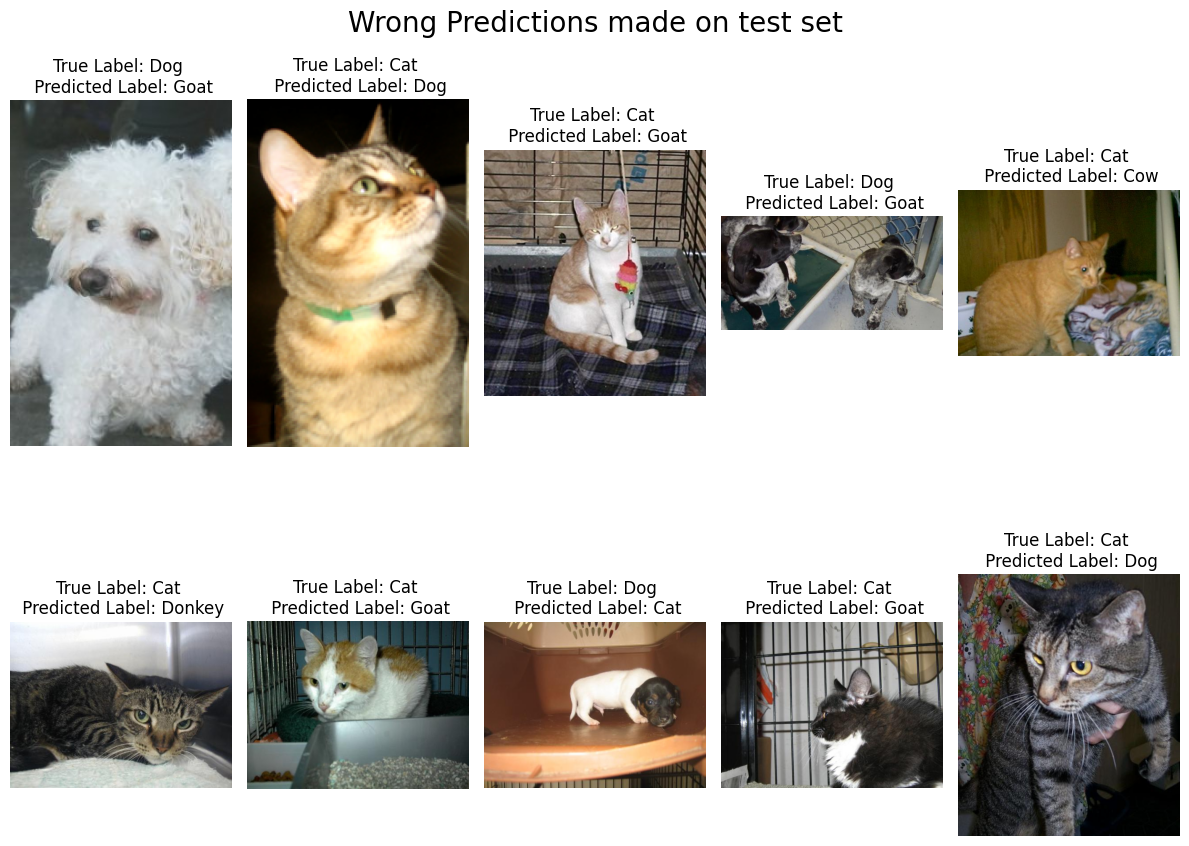

In [38]:
fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(12, 10))
idx = 0

for i in range(2):
    for j in range(5):
        idx = np.random.randint(0, len(test_img))
        true_index = y_true_errors[idx]
        true_label = labels[true_index]
        predicted_index = y_pred_errors[idx]
        predicted_label = labels[predicted_index]
        ax[i, j].set_title(f"True Label: {true_label} \n Predicted Label: {predicted_label}")
        img_path = os.path.join(test_dataset, test_img[idx])
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        ax[i, j].imshow(img)
        ax[i, j].axis("off")

plt.tight_layout()
plt.suptitle('Wrong Predictions made on test set', fontsize=20)
plt.show()